In [461]:
%matplotlib inline
import pandas as pd

In [462]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

In [463]:
from pyxirr import xirr

In [464]:
df = pd.read_csv("data_in_csv.csv", index_col=0,parse_dates=True)

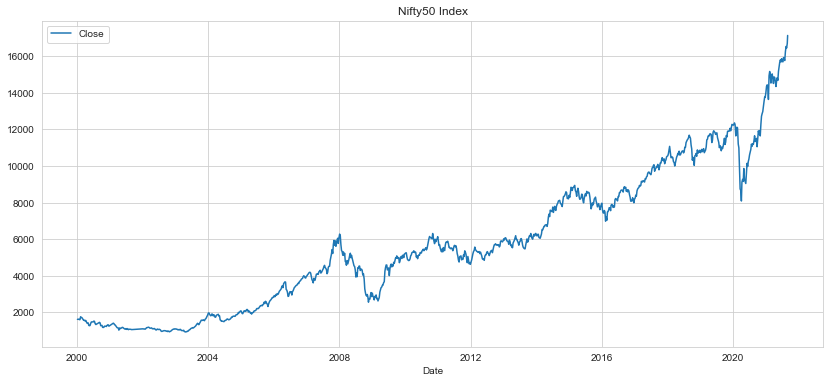

In [465]:
plt.figure(figsize=(14,6))
plt.title("Nifty50 Index")

sns.lineplot(data=df)
sns.set_style("whitegrid")

In [466]:
df = df.rename(columns = {"Close": "close"})

In [486]:
first_year = 2007
last_year = 2021
last_month = 12
start_years = range(first_year, 2014)
start_quarters = [1, 3, 6, 9]
end_years = range(2015, last_year+1)
end_quarters = [3, 6, 9, last_month]

In [487]:
def gen_start_date():
    for y1 in start_years:
        for q1 in start_quarters:
            yield "{}-{}".format(y1, q1)
            
def gen_end_date():
    for y2 in end_years:
        for q2 in end_quarters:
            yield "{}-{}".format(y2, q2)

In [488]:
xirr_all = []
start_dates = [s for s in gen_start_date()]
end_dates = [e for e in gen_end_date()]

for start_date in gen_start_date():
    xirr_idxs = []
    
    for end_date in gen_end_date():
        xirr_index = get_xirr_index(df[start_date: end_date])
        #print("{0} TO {1} XIRR={2:.{3}f}".format(start_date, end_date, xirr_index, 4))
        xirr_idxs.append(xirr_index)
    
    xirr_all.append(xirr_idxs)
    

<AxesSubplot:title={'center':'Nifty50 XIRR'}>

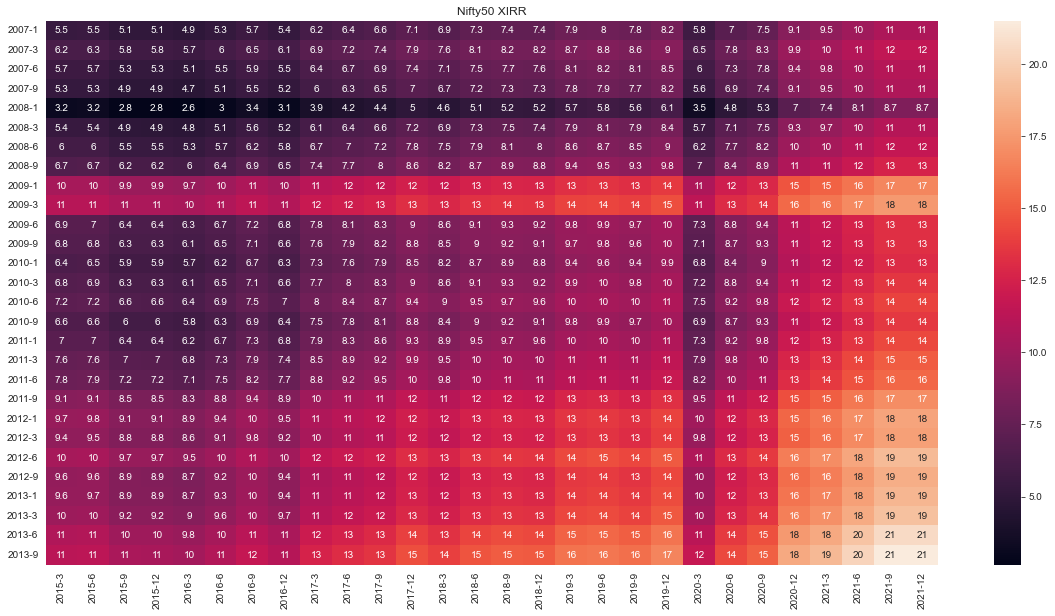

In [491]:
df_xi = pd.DataFrame(xirr_all, columns=end_dates, index=start_dates)
df_xi = df_xi * 100
plt.figure(figsize=(20,10))
plt.title("Nifty50 XIRR")

sns.heatmap(data=df_xi, annot=True)

In [494]:
get_compound_int_mf(.19, 17)

19.24413273135301

In [483]:
expected_RR = 0.13
risk_free_rate = 0.07
starting_sum = 100000
add_on_loss = 0.20
withdraw_on_profit = 0.20

In [458]:
def get_xirr_index(dfw):
    td = (dfw.index[0] - pd.to_datetime(str(first_year)))
    t = td.days/365
    mf = get_compound_int_mf(risk_free_rate, t)
    df3 = dfw.reset_index().iloc[[1, -1]].loc[:, ["Date", "close"]]
    df3 = df3.reset_index()
    del df3["index"]
    df3 = df3.rename(columns={"close": "cash_flow"})
    df3.loc[0, "cash_flow"] = df3.loc[0, "cash_flow"] * -1 / mf    
    
    #update end return
    df3.loc[1, "cash_flow"] = df3.loc[1, "cash_flow"] * emf
    df3.loc[1, "Date"] = pd.to_datetime("{}-{}".format(last_year, last_month))
    xirr_index = xirr(df3)
    return xirr_index

In [427]:
def get_compound_int_mf(r ,t):
    p = 100000
    ci = p * ( 1 +  r)**t
    mf = ci/p
    return mf

In [480]:
dfw = df["2003":]

In [484]:
dfw["pct_change"] = dfw.close.diff()/dfw.close.shift(1)
dfw.loc[:, "weekly_RR"] = 1 + expected_RR/52
dfw.loc[dfw.index[0], "weekly_RR"] = starting_sum
dfw.loc[:, "expected_mean"] = dfw.weekly_RR.cumprod().round(2)
dfw = dfw.reset_index()

first = dfw.loc[0]
dfw.loc[0, "units"] = first.expected_mean/first.close
dfw.loc[0, "current_value"] = starting_sum

for i in range(1, len(dfw)):
    buy_event = False
    sell_event = False
    
    prev_row = dfw.loc[i-1]
    curr_row = dfw.loc[i]
    close_val = curr_row["close"]
    curr_exp_mean = curr_row["expected_mean"]
    
    prev_exp_mean = prev_row["expected_mean"]
    prev_units = prev_row["units"]
    prev_curr_val = prev_row["current_value"]
    
    curr_mkt_val = close_val * prev_units
    
    if curr_mkt_val < (1 - add_on_loss) * curr_exp_mean:
        buy_event = True
    elif curr_mkt_val > (1 + withdraw_on_profit) * curr_exp_mean:
        sell_event = True
    
    dfw.loc[i, "buy_event"] = buy_event
    dfw.loc[i, "sell_event"] = sell_event
    
    if buy_event or sell_event:
        dfw.loc[i, "residual"] = curr_mkt_val - curr_exp_mean
    else:
        dfw.loc[i, "residual"] = 0    
    
    if buy_event or sell_event:
        dfw.loc[i, "units"] = curr_exp_mean / close_val
    else:
        dfw.loc[i, "units"] = dfw.loc[i-1, "units"]

    curr_row = dfw.loc[i]      
    dfw.loc[i, "current_value"] = curr_row.close * curr_row.units
    curr_row = dfw.loc[i]

    
dfw["cum_residual"] = dfw.residual.cumsum()
dfw["total_value"] = dfw.current_value + dfw.cum_residual
dfw = dfw.set_index("Date")

#xirr calculations
df1 = dfw.reset_index().iloc[[1, -1]].loc[:, ["Date", "total_value"]]
df1 = df1.rename(columns={"total_value": "cash_flow"})
df1.loc[1, "cash_flow"] = df1.loc[1, "cash_flow"] * -1

df2 = dfw[(dfw["residual"] != 0) & (dfw["residual"].notna())].reset_index().loc[:, ["Date", "residual"]]
df2 = df2.rename(columns={"residual": "cash_flow"})

irr_df = pd.concat([df1, df2])
irr_df = irr_df.set_index("Date").sort_index().reset_index()
xirr_folio = xirr(irr_df)
xirr_folio

0.22129803778219934

<AxesSubplot:xlabel='Date'>

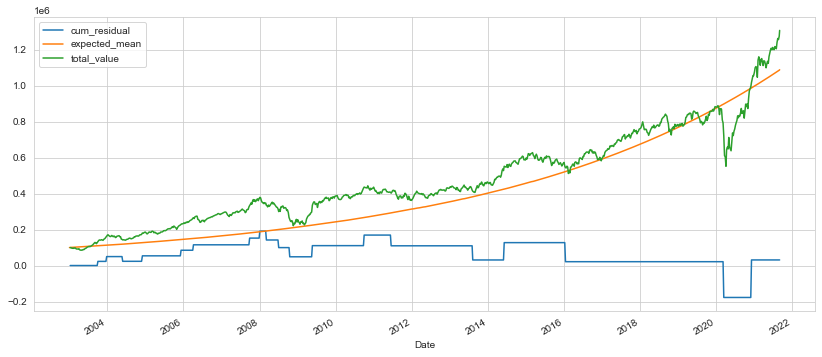

In [485]:
dfw.loc[:, ["cum_residual", "expected_mean", "total_value"]].plot(figsize=(14,6))